In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
import simpy

# Parameter Simulasi

In [ ]:
RANDOM_SEED = 42
NUM_TELLERS = [1, 2, 3]  
ARRIVAL_RATE = 5  # Kedatangan pelanggan per menit
PEAK_HOUR_FACTOR = 2  # Faktor peningkatan saat jam sibuk
SERVICE_RATE = 7  # Layanan teller per menit
SIM_TIME = 20  # Waktu simulasi dalam menit
VIP_PROB = 0.3  # Probabilitas pelanggan VIP

In [ ]:
wait_times = {tellers: [] for tellers in NUM_TELLERS}
utilization_rates = {tellers: [] for tellers in NUM_TELLERS}

In [41]:
class BankQueueSimulation:
    def __init__(self, env, num_tellers, service_rate):
        self.env = env
        self.teller = simpy.PriorityResource(env, num_tellers)
        self.service_rate = service_rate
        self.busy_tellers = 0
        self.utilization = []

    def serve_customer(self, customer_id):
        """Memproses layanan pelanggan oleh teller."""
        service_time = random.expovariate(self.service_rate)
        yield self.env.timeout(service_time)
        self.busy_tellers -= 1

    def update_utilization(self, num_tellers):
        """Memperbarui tingkat utilisasi teller."""
        self.utilization.append(self.busy_tellers / num_tellers)


In [42]:
def customer_process(env, customer_id, bank, is_vip, num_tellers):
    """Proses pelanggan masuk ke antrean."""
    arrival_time = env.now
    priority = 0 if is_vip else 1  # VIP memiliki prioritas lebih tinggi
    
    with bank.teller.request(priority=priority) as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times[num_tellers].append(wait_time)
        
        bank.busy_tellers += 1
        bank.update_utilization(num_tellers)
        yield env.process(bank.serve_customer(customer_id))

def customer_arrivals(env, bank, arrival_rate, num_tellers):
    """Proses kedatangan pelanggan ke bank."""
    customer_id = 0
    while True:
        if 5 <= env.now <= 10:
            arrival_time = random.expovariate(arrival_rate * PEAK_HOUR_FACTOR)
        else:
            arrival_time = random.expovariate(arrival_rate)
        yield env.timeout(arrival_time)
        customer_id += 1
        is_vip = random.random() < VIP_PROB
        env.process(customer_process(env, customer_id, bank, is_vip, num_tellers))


In [ ]:
def run_simulation(num_tellers):
    """Menjalankan simulasi antrean bank dengan jumlah teller tertentu."""
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    bank = BankQueueSimulation(env, num_tellers, SERVICE_RATE)
    env.process(customer_arrivals(env, bank, ARRIVAL_RATE, num_tellers))
    env.run(until=SIM_TIME)
    
    utilization_rates[num_tellers] = bank.utilization.copy()  


In [44]:
# Menjalankan simulasi untuk berbagai jumlah teller
for tellers in NUM_TELLERS:
    print(f"\n=== Running simulation with {tellers} tellers ===")
    run_simulation(tellers)

# Menampilkan rata-rata waktu tunggu
for tellers in NUM_TELLERS:
    avg_wait_time = np.mean(wait_times[tellers]) if wait_times[tellers] else 0  # Rata-rata waktu tunggu
    print(f"Rata-rata waktu tunggu dengan {tellers} teller: {avg_wait_time:.2f} menit")



=== Running simulation with 1 tellers ===

=== Running simulation with 2 tellers ===

=== Running simulation with 3 tellers ===
Rata-rata waktu tunggu dengan 1 teller: 2.19 menit
Rata-rata waktu tunggu dengan 2 teller: 0.09 menit
Rata-rata waktu tunggu dengan 3 teller: 0.01 menit


# Visualisasi hasil simulasi

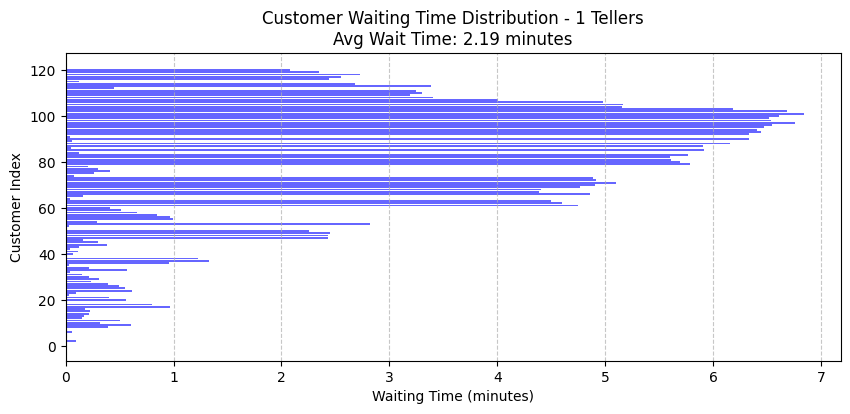

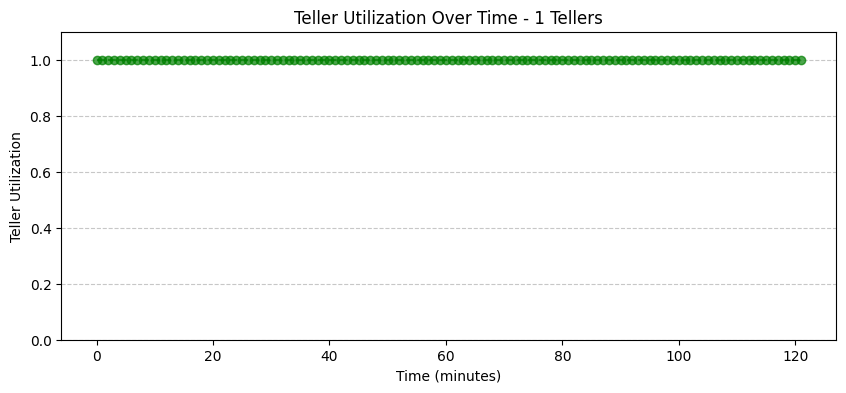

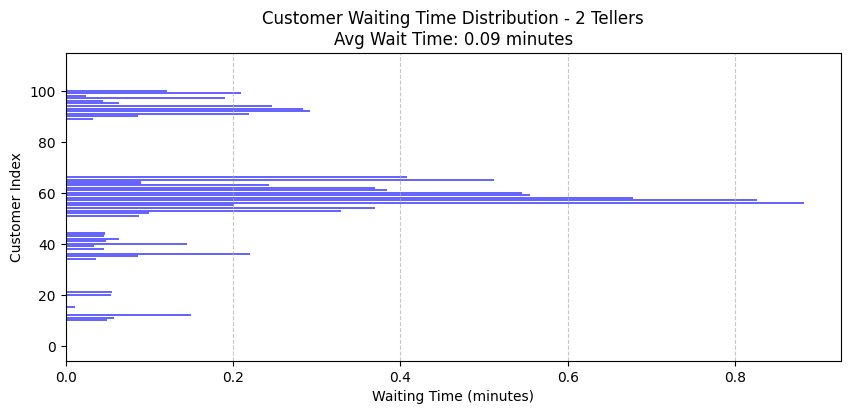

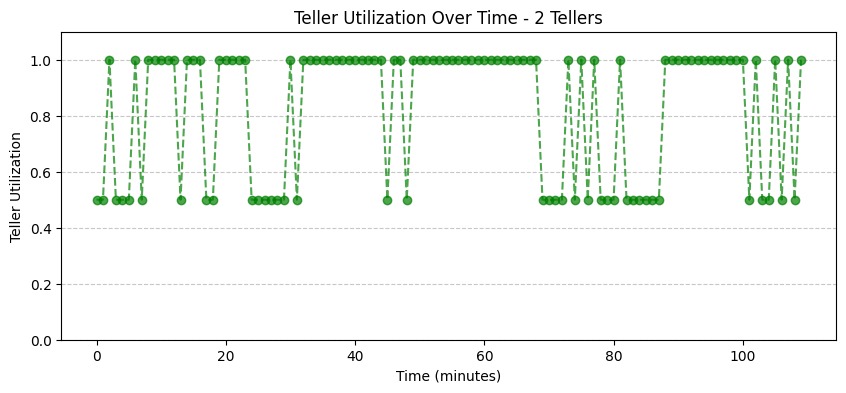

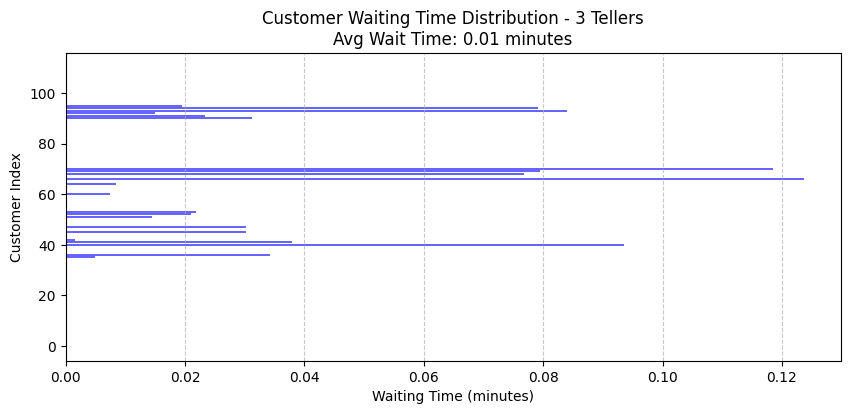

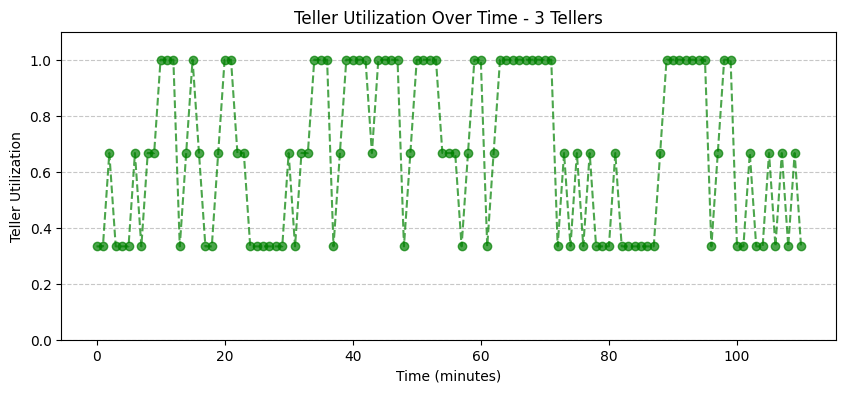

In [ ]:
for tellers in NUM_TELLERS:
    avg_wait_time = np.mean(wait_times[tellers]) if wait_times[tellers] else 0  # Rata-rata waktu tunggu

    # Grafik Distribusi Waktu Tunggu Pelanggan
    plt.figure(figsize=(10, 4))
    plt.barh(range(len(wait_times[tellers])), wait_times[tellers], color='blue', alpha=0.6)
    plt.xlabel("Waiting Time (minutes)")
    plt.ylabel("Customer Index")
    plt.title(f"Customer Waiting Time Distribution - {tellers} Tellers\nAvg Wait Time: {avg_wait_time:.2f} minutes")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()
    
    # Grafik Utilisasi Teller Seiring Waktu
    plt.figure(figsize=(10, 4))
    plt.plot(utilization_rates[tellers], color='green', alpha=0.7, marker='o', linestyle='dashed')
    plt.xlabel("Time (minutes)")
    plt.ylabel("Teller Utilization")
    plt.ylim(0, 1.1)
    plt.title(f"Teller Utilization Over Time - {tellers} Tellers")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
